In [1]:
import pyrootutils
from pathlib import Path

# Point to your repo root manually
root = pyrootutils.setup_root(
    Path().resolve().parent,  # current working dir
    project_root_env_var=True,
    dotenv=True,
    pythonpath=True,
    cwd=False,
)

In [2]:
import numpy as np
import torch
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.cluster import KMeans
from skimage import filters, morphology, exposure, measure, morphology, segmentation

from src.data_modules.hsi_dermoscopy import HSIDermoscopyDataModule
from src.data_modules.datasets.hsi_dermoscopy_dataset import HSIDermoscopyTask

/mnt/data/kristhian/miniforge3/envs/hyper/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_module = HSIDermoscopyDataModule(data_dir="../data/hsi_dermoscopy",
    task=HSIDermoscopyTask.SEGMENTATION,
                                      train_val_test_split=[.70, .15, .15],
                                      batch_size=16,
                                      transforms=None)
data_module.prepare_data()
data_module.setup()
data_loader = data_module.all_dataloader()
dataset = data_loader.dataset

In [4]:
# get first sample
image, mask, label = dataset[0]
print(f"Image shape: {image.shape}, Mask: {mask.shape}, Label: {label}")

Image shape: (272, 512, 16), Mask: torch.Size([272, 512]), Label: 0


In [5]:
def get_non_border_mask(image, iterations=20, threshold=0.1):
    mean_image = image.mean(axis=-1)
    otsu_thresh = filters.threshold_otsu(mean_image)
    binary_mask = mean_image > otsu_thresh
    cleaned_mask = morphology.remove_small_objects(binary_mask, min_size=500)

    contours, _ = cv2.findContours(cleaned_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    hull = cv2.convexHull(contours[0])
    hull_mask = np.zeros_like(cleaned_mask.astype(np.uint8))
    cv2.drawContours(hull_mask, [hull], -1, 255, -1)
    cleaned_mask = hull_mask.astype(bool)

    return cleaned_mask

non_border_mask = get_non_border_mask(image)

In [6]:
# Reverse map integer label -> string name
inverse_labels_map = {v: k for k, v in dataset.dataset.labels_map.items()}

inverse_labels_map[len(inverse_labels_map)] = "normal_skin"  # background class

def compute_spectra_stats(dataset, inverse_labels_map, get_non_border_mask, use_tqdm=True, desc="Calculating spectra"):
    """
    Iterate over a dataset and collect per-label spectra and summary stats.
    Returns (spectra_by_label, stats) where:
      - spectra_by_label: dict[label_name] -> list of spectra (ndarray, bands)
      - stats: dict[label_name] -> {"mean": ndarray, "std": ndarray}
    """
    spectra_by_label = {}
    iterator = range(len(dataset))
    if use_tqdm:
        iterator = tqdm.tqdm(iterator, desc=desc)

    for i in iterator:
        image, mask, label = dataset[i]

        # ensure numpy arrays for mask and label
        mask_np = mask.numpy() if hasattr(mask, "numpy") else np.array(mask)
        label_int = label.item() if hasattr(label, "item") else int(label)
        label_name = inverse_labels_map[label_int]

        # collect spectrum for the object mask (where mask == 1)
        obj_mask = mask_np == 1
        if np.any(obj_mask):
            spectrum = image[obj_mask].mean(axis=0)
            spectra_by_label.setdefault(label_name, []).append(spectrum)

        # collect a "normal_skin" spectrum from non-border areas that are background (mask == 0)
        nb_mask = get_non_border_mask(image)
        normal_skin_mask = nb_mask & (mask_np == 0)
        if np.any(normal_skin_mask):
            normal_spectrum = image[normal_skin_mask].mean(axis=0)
            spectra_by_label.setdefault("normal_skin", []).append(normal_spectrum)

    # Compute mean and std for each label
    stats = {}
    for label_name, spectra in spectra_by_label.items():
        arr = np.array(spectra)
        stats[label_name] = {
            "mean": np.mean(arr, axis=0),
            "std": np.std(arr, axis=0),
        }

    return spectra_by_label, stats

# Run the function to produce the same outputs as before
spectra_by_label, stats = compute_spectra_stats(dataset, inverse_labels_map, get_non_border_mask)

Calculating spectra: 100%|██████████| 312/312 [00:19<00:00, 15.97it/s]


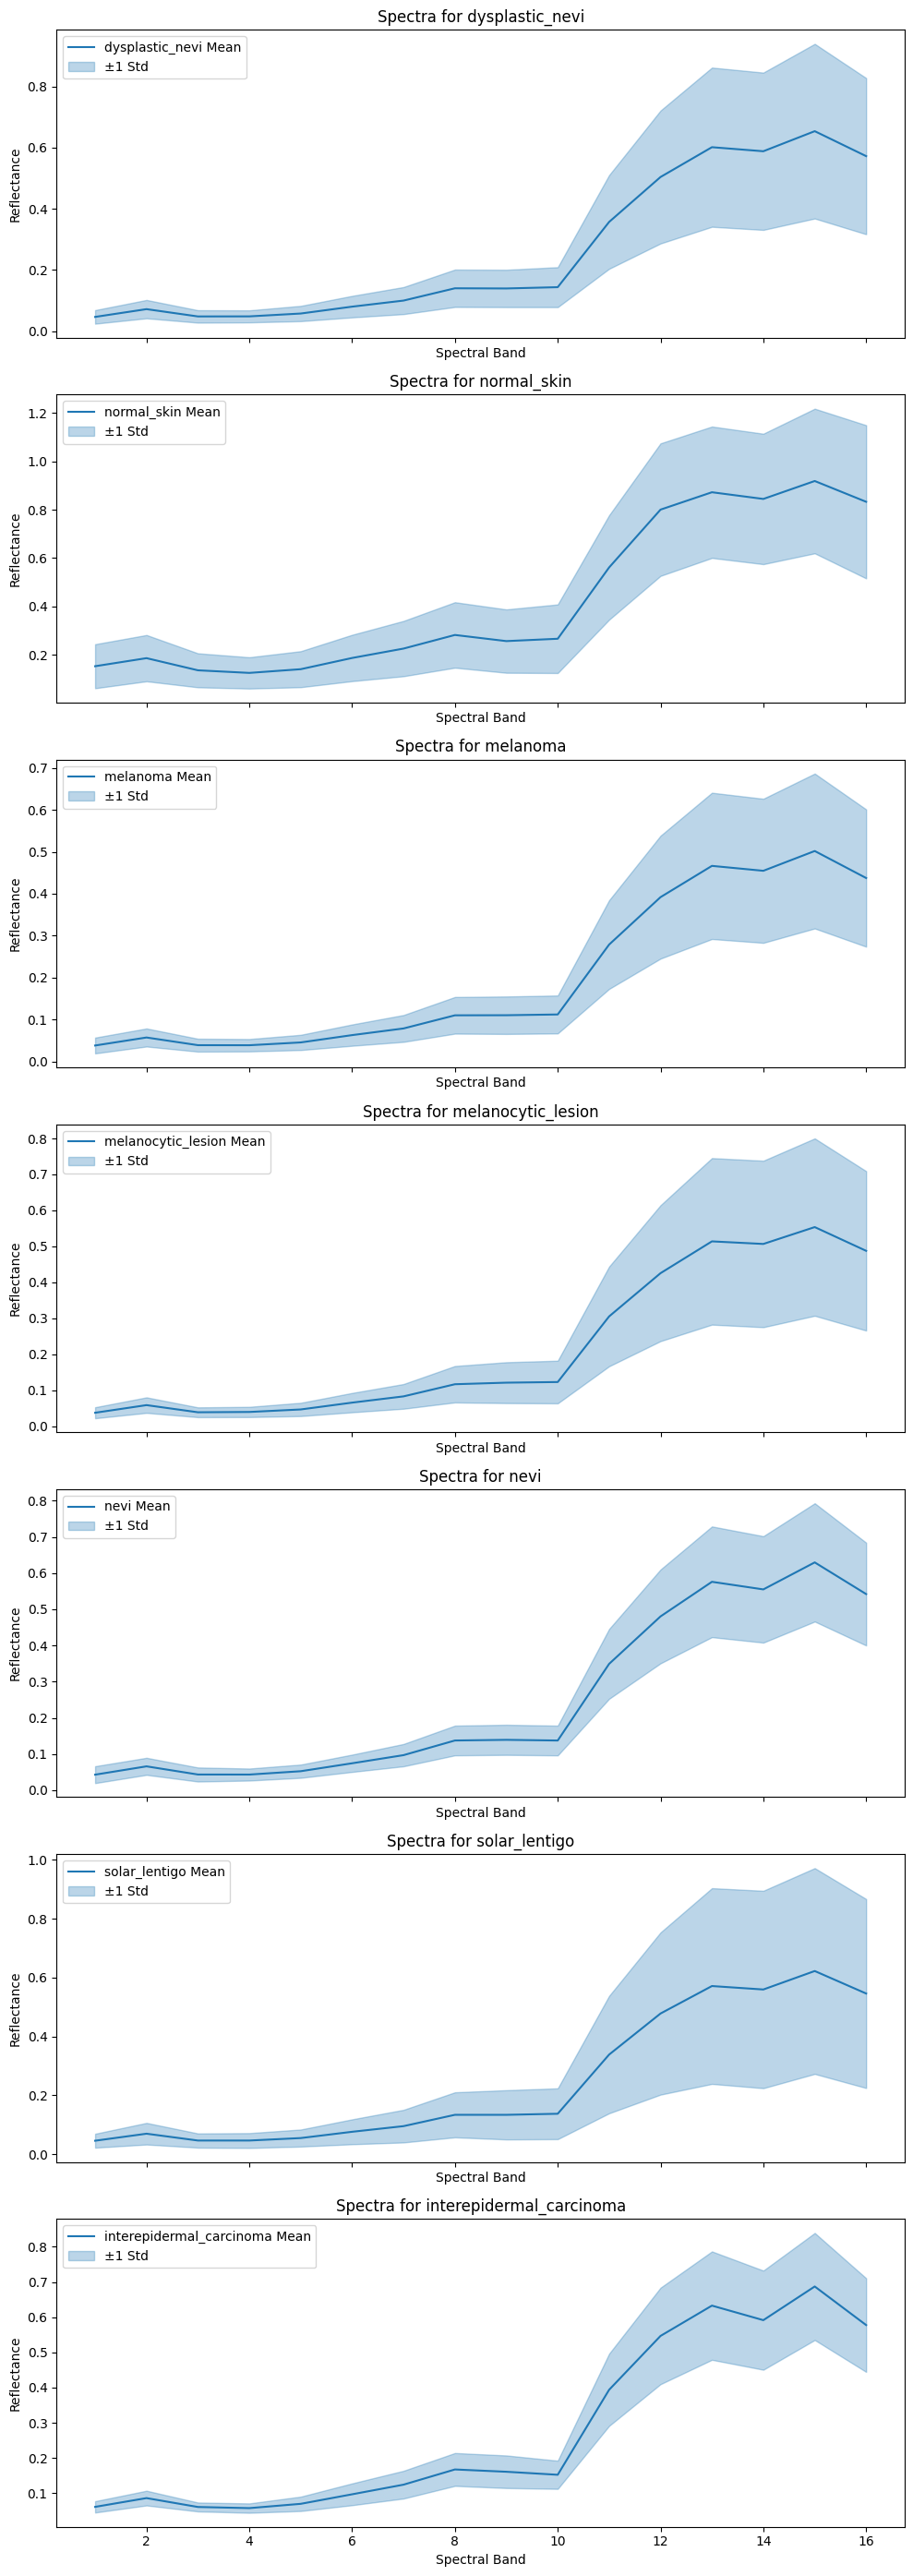

In [7]:
# Plot each label in its own subplot
n_labels = len(stats)
fig, axes = plt.subplots(
    n_labels, 1, figsize=(10, 4 * n_labels), sharex=True
)

if n_labels == 1:  # ensure axes is iterable for one subplot
    axes = [axes]

for ax, (label, values) in zip(axes, stats.items()):
    mean = values["mean"]
    std = values["std"]
    bands = np.arange(1, len(mean) + 1)

    ax.plot(bands, mean, label=f"{label} Mean", color="C0")
    ax.fill_between(
        bands, mean - std, mean + std, alpha=0.3, color="C0", label="±1 Std"
    )
    ax.set_title(f"Spectra for {label}")
    ax.set_xlabel("Spectral Band")
    ax.set_ylabel("Reflectance")
    ax.legend()

plt.tight_layout()
plt.show()

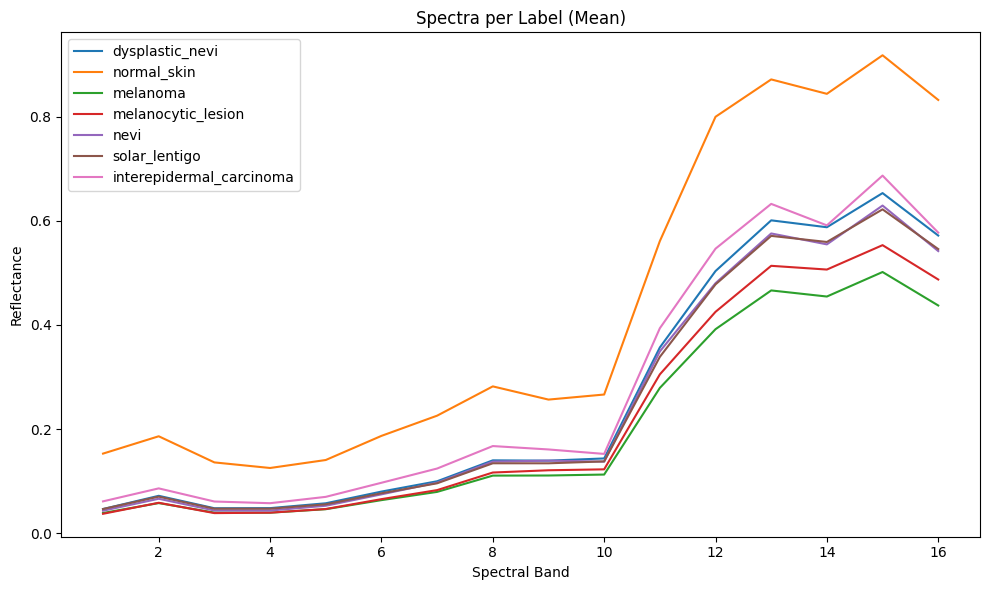

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, (label, values) in enumerate(stats.items()):
    mean = values["mean"]
    bands = np.arange(1, len(mean) + 1)

    color = f"C{i % 10}"  # cycle through Matplotlib's default colors
    ax.plot(bands, mean, label=label, color=color)

ax.set_title("Spectra per Label (Mean)")
ax.set_xlabel("Spectral Band")
ax.set_ylabel("Reflectance")
ax.legend()
plt.tight_layout()
plt.show()


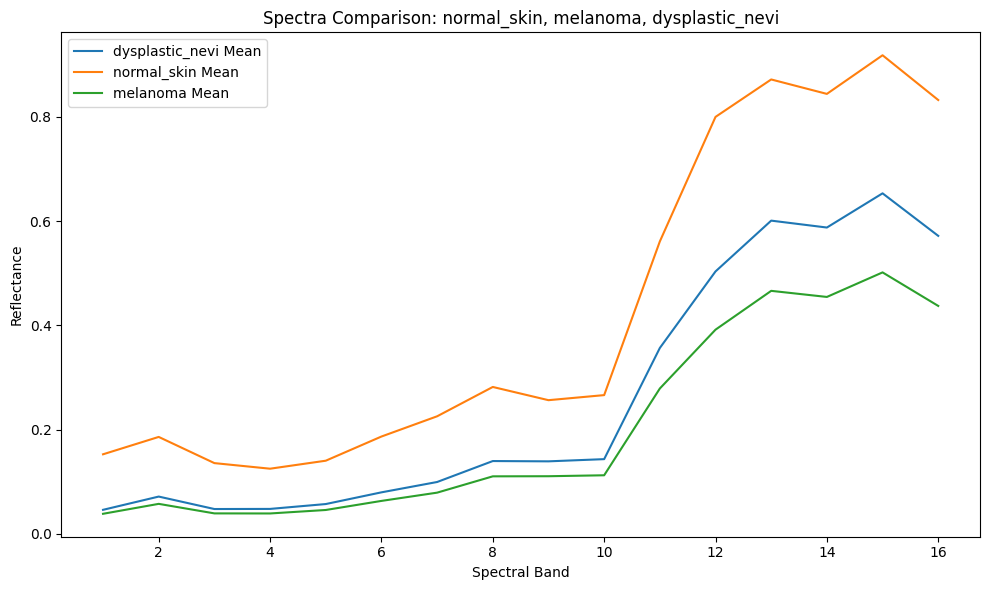

In [9]:
# Define which labels you want to plot
labels_to_plot = ["normal_skin", "melanoma", "dysplastic_nevi"]

# Filter stats to only keep the selected labels
filtered_stats = {
    label: values for label, values in stats.items() if label in labels_to_plot
}

# Toggle standard deviation shading
show_std = False  # <-- set this to False if you don't want the shaded area

# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

bands = np.arange(1, len(next(iter(filtered_stats.values()))["mean"]) + 1)

# Plot each label on the same axes
for i, (label, values) in enumerate(filtered_stats.items()):
    mean = values["mean"]
    std = values["std"]

    ax.plot(bands, mean, label=f"{label} Mean", color=f"C{i}")

    if show_std:
        ax.fill_between(
            bands, mean - std, mean + std, alpha=0.2, color=f"C{i}"
        )

ax.set_title("Spectra Comparison: normal_skin, melanoma, dysplastic_nevi")
ax.set_xlabel("Spectral Band")
ax.set_ylabel("Reflectance")
ax.legend()
plt.tight_layout()
plt.show()

/mnt/data/kristhian/miniforge3/envs/hyper/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


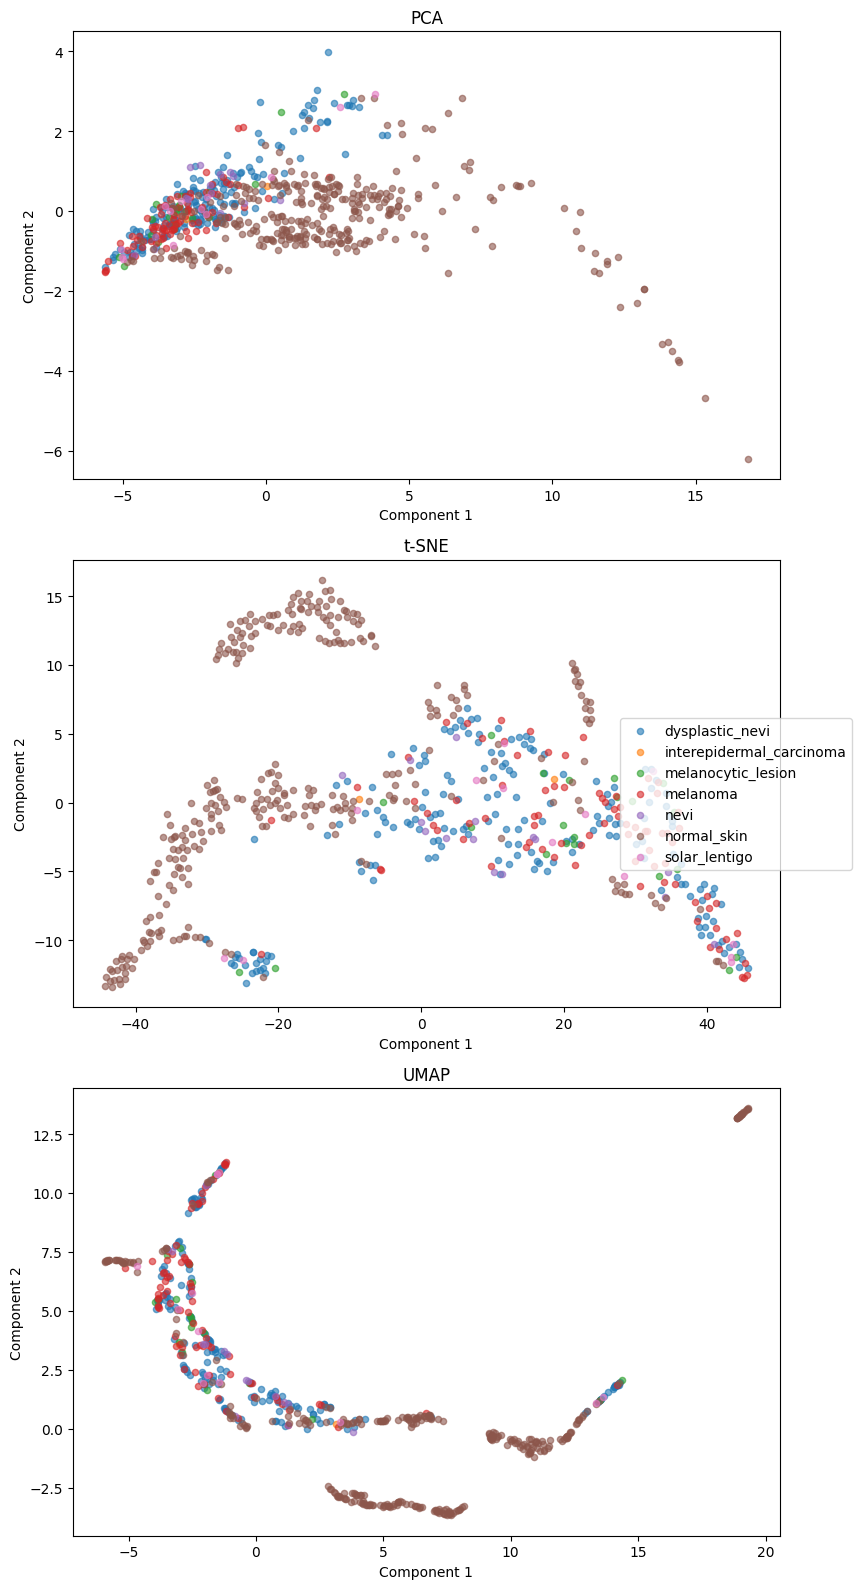

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# --------------------------
# Prepare data (from spectra_by_label)
# --------------------------
X = []  # spectra
y = []  # labels

for label, spectra in spectra_by_label.items():
    for spec in spectra:
        X.append(spec)
        y.append(label)

X = np.array(X)
y = np.array(y)

# Optional: normalize spectra across channels
X = (X - X.mean(axis=0)) / X.std(axis=0)

# --------------------------
# Dimensionality reduction
# --------------------------
X_pca = PCA(n_components=2).fit_transform(X)

X_tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="random",
    random_state=42
).fit_transform(X)

X_umap = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
).fit_transform(X)

# --------------------------
# Plot helper function
# --------------------------
def plot_scatter(ax, X_2d, labels, title):
    unique_labels = np.unique(labels)
    for label in unique_labels:
        mask = labels == label
        ax.scatter(
            X_2d[mask, 0],
            X_2d[mask, 1],
            label=label,
            alpha=0.6,
            s=20
        )
    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")

# --------------------------
# Create one figure with subplots
# --------------------------
fig, axes = plt.subplots(3, 1, figsize=(8, 16))

plot_scatter(axes[0], X_pca, y, "PCA")
plot_scatter(axes[1], X_tsne, y, "t-SNE")
plot_scatter(axes[2], X_umap, y, "UMAP")

# Put one legend outside (instead of repeating)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.08, 0.5))

plt.tight_layout()
plt.show()

Calculating spectra: 100%|██████████| 59/59 [00:00<00:00, 189.51it/s]


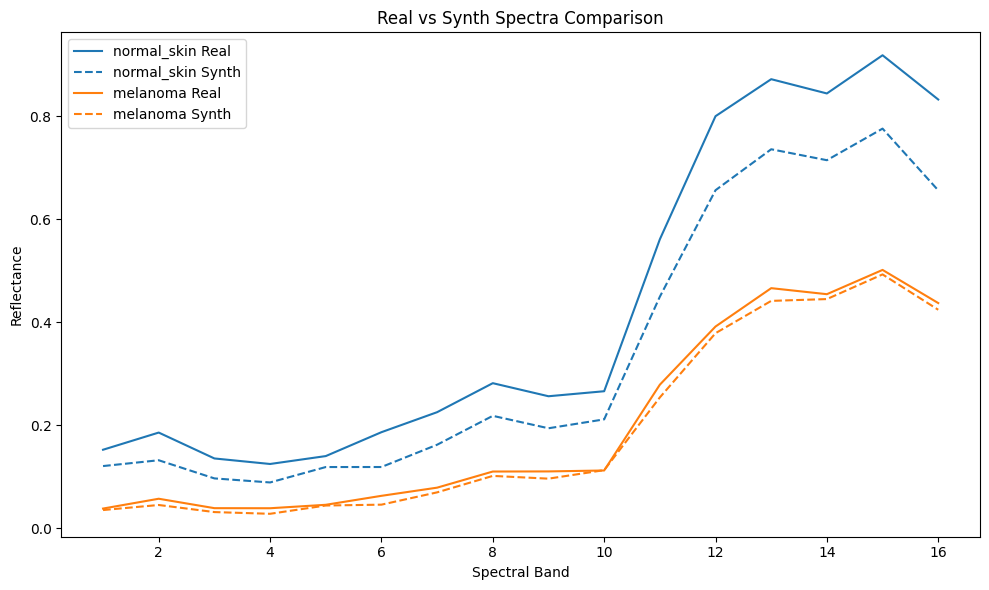

In [11]:
from src.data_modules.datasets.hsi_dermoscopy_dataset import HSIDermoscopyDataset

dataset = HSIDermoscopyDataset(task=HSIDermoscopyTask.GENERATION, data_dir="../data/hsi_dermoscopy_cropped_synth")

use_tqdm = True

spectra_by_label = {}
iterator = range(len(dataset))
if use_tqdm:
    iterator = tqdm.tqdm(iterator, desc="Calculating spectra")

for i in iterator:
    if i in [51, 54, 41, 26, 13, 26, 56, 50, 33, 51]:
        continue

    image, label = dataset[i]

    mean_image = image.mean(axis=-1)
    otsu_thresh = filters.threshold_otsu(mean_image)
    binary_mask = mean_image < (otsu_thresh * 1)
    mask_np = morphology.remove_small_objects(binary_mask, min_size=500)

    # ensure numpy arrays for mask and label
    label_int = label.item() if hasattr(label, "item") else int(label)
    label_name = inverse_labels_map[label_int]

    # collect spectrum for the object mask (where mask == 1)
    if np.any(mask_np):
        spectrum = image[mask_np].mean(axis=0)
        spectra_by_label.setdefault(label_name, []).append(spectrum)

    # collect a "normal_skin" spectrum from non-border areas that are background (mask == 0)
    normal_skin_mask = ~mask_np
    if np.any(normal_skin_mask):
        normal_spectrum = image[normal_skin_mask].mean(axis=0)
        spectra_by_label.setdefault("normal_skin", []).append(normal_spectrum)

# Compute mean and std for each label
synth_stats = {}
for label_name, spectra in spectra_by_label.items():
    arr = np.array(spectra)
    synth_stats[label_name] = {
        "mean": np.mean(arr, axis=0),
        "std": np.std(arr, axis=0),
    }

# Toggle standard deviation shading (set True to show ±1 std)
show_std = False  # change to True to enable shading
# labels_to_plot = ["normal_skin", "melanoma", ]
# plot synth_stats vs real stats for selected labels on the same axes
fig, ax = plt.subplots(figsize=(10, 6))
for i, label in enumerate(labels_to_plot):
    real_values = stats.get(label)
    synth_values = synth_stats.get(label)

    if real_values is None or synth_values is None:
        continue

    real_mean = real_values["mean"]
    real_std = real_values.get("std", None)
    synth_mean = synth_values["mean"]
    synth_std = synth_values.get("std", None)
    bands = np.arange(1, len(real_mean) + 1)

    color = f"C{i}"
    ax.plot(bands, real_mean, label=f"{label} Real", linestyle='-', color=color)
    ax.plot(bands, synth_mean, label=f"{label} Synth", linestyle='--', color=color)

    if show_std:
        if real_std is not None:
            ax.fill_between(bands, real_mean - real_std, real_mean + real_std, alpha=0.2, color=color)
        if synth_std is not None:
            ax.fill_between(bands, synth_mean - synth_std, synth_mean + synth_std, alpha=0.1, color=color)

ax.set_title("Real vs Synth Spectra Comparison")
ax.set_xlabel("Spectral Band")
ax.set_ylabel("Reflectance")
ax.legend()
plt.tight_layout()
plt.show()